# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
from scipy.stats.mstats import mode
import seaborn as sns
import os
from glob import glob
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
csv_files = glob("./q2Data/*.csv.gz")
csv_files

['./q2Data\\imdb.name.basics.csv.gz',
 './q2Data\\imdb.title.akas.csv.gz',
 './q2Data\\imdb.title.basics.csv.gz',
 './q2Data\\imdb.title.crew.csv.gz',
 './q2Data\\imdb.title.principals.csv.gz',
 './q2Data\\imdb.title.ratings.csv.gz']

In [3]:
type(csv_files)

list

In [4]:
d = dict()
for file in csv_files:
    d[file] = pd.read_csv(file)

In [5]:
csv_files_dict = dict()
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv","").replace(".gz","").replace(".","_") # cleaning file names
    filename_df = pd.read_csv(filename, index_col=None)
    csv_files_dict[filename_cleaned] = filename_df

In [6]:
csv_files_dict.keys()

dict_keys(['imdb_name_basics', 'imdb_title_akas', 'imdb_title_basics', 'imdb_title_crew', 'imdb_title_principals', 'imdb_title_ratings'])

In [7]:
conn = sqlite3.Connection('./q2Data/movies_db.sqlite')

In [8]:
def create_sql_table_from_df(df, name, conn):
    try:
        df.to_sql(name, conn)
        print(f"Created sql table {name}")
    
    except Exception as e:
        print(f"Couldn't make sql table {name}")
        print(e)

In [9]:
for name, table in csv_files_dict.items():
    create_sql_table_from_df(table, name, conn)

Couldn't make sql table imdb_name_basics
Table 'imdb_name_basics' already exists.
Couldn't make sql table imdb_title_akas
Table 'imdb_title_akas' already exists.
Couldn't make sql table imdb_title_basics
Table 'imdb_title_basics' already exists.
Couldn't make sql table imdb_title_crew
Table 'imdb_title_crew' already exists.
Couldn't make sql table imdb_title_principals
Table 'imdb_title_principals' already exists.
Couldn't make sql table imdb_title_ratings
Table 'imdb_title_ratings' already exists.


In [10]:
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',)]

In [11]:
for item in csv_files_dict.items():
    print("******** NEW DF **********")
    print(item[0])
    print(item[1].info())
    print("******** END DF **********")

******** NEW DF **********
imdb_name_basics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
birth_year            82736 non-null float64
death_year            6783 non-null float64
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: float64(2), object(4)
memory usage: 27.8+ MB
None
******** END DF **********
******** NEW DF **********
imdb_title_akas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
title_id             331703 non-null object
ordering             331703 non-null int64
title                331703 non-null object
region               278410 non-null object
language             41715 non-null object
types                168447 non-null object
attributes           14925 non-null object
is_original_title    331678 non-nu

# 1 Data Cleaning

## 1.1 Dealing with datatypes

In [12]:
### change dtype of columns
# we want to change the types of 3 columns. Good idea to write a function for this

def convert_amt_to_int(df, col):
    df[col] = df[col].str.replace("$","").str.replace(",","").astype('float64')
    return df

## 1.2 Dealing with missing values
### 1.2.1 Removing empty columns from all dataframes

In [13]:
### scan through all columns and check portion of missing data
# we want to delete columns with more than 80% of data missing

def remove_empty_cols(df, col, cut):
    if df[col].isna().value_counts(normalize=True, sort=False)[0] < cut: # False < 20% (or True > 80%)
        print(f"\t col['{col}'] deleted b/c {round(100-df[col].isna().value_counts(normalize=True,sort=False)[0]*100,2)}% data missing.")
        df.drop(col, axis=1, inplace=True)
    else:
        print(f"\t col['{col}'] stayed.")
    return df

In [14]:
for nm, tb in csv_files_dict.items():
    print(f"\n")
    print(f"Viewing dataframe: {nm}")
    for tc in tb.columns:
        remove_empty_cols(tb, tc, 0.2) # if only less than 20% data, column removed. otherwise, kept! 



Viewing dataframe: imdb_name_basics
	 col['nconst'] stayed.
	 col['primary_name'] stayed.
	 col['birth_year'] deleted b/c 86.36% data missing.
	 col['death_year'] deleted b/c 98.88% data missing.
	 col['primary_profession'] stayed.
	 col['known_for_titles'] stayed.


Viewing dataframe: imdb_title_akas
	 col['title_id'] stayed.
	 col['ordering'] stayed.
	 col['title'] stayed.
	 col['region'] stayed.
	 col['language'] deleted b/c 87.42% data missing.
	 col['types'] stayed.
	 col['attributes'] deleted b/c 95.5% data missing.
	 col['is_original_title'] stayed.


Viewing dataframe: imdb_title_basics
	 col['tconst'] stayed.
	 col['primary_title'] stayed.
	 col['original_title'] stayed.
	 col['start_year'] stayed.
	 col['runtime_minutes'] stayed.
	 col['genres'] stayed.


Viewing dataframe: imdb_title_crew
	 col['tconst'] stayed.
	 col['directors'] stayed.
	 col['writers'] stayed.


Viewing dataframe: imdb_title_principals
	 col['tconst'] stayed.
	 col['ordering'] stayed.
	 col['nconst'] st

### 1.2.2 Deleting one individual column (dim. reduction) completely from one dataframe

In [15]:
def remove_column(df, col):
    df.drop(col, axis=1, inplace=True)
    return df

### 1.2.3 Deleting one individual row (redundant removal) completely from one dataframe

In [16]:
def remove_row(df, rowidx):
    df.drop(rowidx, axis=0, inplace=True)
    return df

### 1.2.4 Deleting several empty rows from one given column in one dataframe

In [17]:
def remove_empty_rows(df, col, cut): # if less than 10% data missing in one given column, deleted. otherwise, kept!
    rm_rows = list(df[df[col].isna()==True].index)
    row_len = df.shape[0]
    print(f"empty row portion {round((len(rm_rows)/len(df[col]))*100,3)}% in col['{col}']")
    if len(rm_rows)/df.shape[0] < cut:
        df.dropna(subset=[col], how='any', thresh=1, inplace=True)
    now_len = df.shape[0]
    print(f"\t >>>>>> empty row portion {round(100-(now_len/row_len)*100,3)}% in col['{col}']")
    return df

### 1.2.5 Checking and Removing duplicated rows from all dataframes

In [18]:
# we require ALL duplicated rows be deleted

def check_duplicate_rows(df):
    df['is_duplicated'] = df.duplicated(subset=None, keep='first')
    if df.is_duplicated.value_counts(normalize=True, sort=False)[0] == 1: # 100% False 
        print(f'\t no duplicated rows found!')
        df.drop('is_duplicated', axis=1, inplace=True)
        return False
    else:
        print(f'\t duplicated rows found!')
        df.drop('is_duplicated', axis=1, inplace=True)
        return True

In [19]:
def remove_duplicate_rows(name, df):
    try:
        df.drop_duplicates()
        print(f"Dropped duplicated rows in dataframe {name}")
        
    except Exception as e:
        print(e)

In [20]:
for nm, tb in csv_files_dict.items():
    print(f"Viewing dataframe: {nm}")
    if check_duplicate_rows(tb):
        remove_duplicate_rows(nm, tb)

Viewing dataframe: imdb_name_basics
	 no duplicated rows found!
Viewing dataframe: imdb_title_akas
	 no duplicated rows found!
Viewing dataframe: imdb_title_basics
	 no duplicated rows found!
Viewing dataframe: imdb_title_crew
	 no duplicated rows found!
Viewing dataframe: imdb_title_principals
	 no duplicated rows found!
Viewing dataframe: imdb_title_ratings
	 no duplicated rows found!


### 1.2.6 Sorting one dataframe by one given column in descending way

In [21]:
def sorted_dataframe(df, col):
    df.sort_values(by=col, ascending=False, inplace=True)
    return df

## 1.3 Combining dataframes
### 1.3.1 Pandas merge

we want to combine five tables together. before doing that, lets check their dimensions.

In [22]:
print(csv_files_dict['imdb_title_ratings'].shape)
print(csv_files_dict['imdb_title_crew'].shape)
print(csv_files_dict['imdb_title_basics'].shape)
print(csv_files_dict['imdb_title_principals'].shape)
print(csv_files_dict['imdb_name_basics'].shape)

(73856, 3)
(146144, 3)
(146144, 6)
(1028186, 5)
(606648, 4)


In [23]:
names_df = pd.merge(csv_files_dict['imdb_name_basics'], csv_files_dict['imdb_title_principals'], on='nconst', how='inner')
print(names_df.shape)
names_df.head(20)

(1027912, 8)


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,9,producer,NaN
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt0433397,7,composer,NaN
2,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt1681372,8,composer,NaN
3,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt2387710,8,composer,NaN
4,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt2281215,7,composer,NaN
5,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt2749258,8,composer,NaN
6,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",tt3564200,9,composer,NaN
7,nm0062070,Bruce Baum,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898",tt6463956,4,actor,"[""Shecky""]"
8,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387",tt2547632,10,cinematographer,NaN
9,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387",tt7697870,8,cinematographer,NaN


In [24]:
genres_df = pd.merge(names_df, csv_files_dict['imdb_title_basics'], on='tconst', how='inner')
print(genres_df.shape)
genres_df.head(20)

(1027912, 13)


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters,primary_title,original_title,start_year,runtime_minutes,genres
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,9,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
2,nm0449549,Jordan Kerner,"producer,actor,executive","tt0101921,tt0141369,tt0119190,tt0108333",tt2398241,10,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
3,nm0962596,Pamela Ribon,"writer,producer,actress","tt0898332,tt3521164,tt5848272,tt2458776",tt2398241,7,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
4,nm0678963,Peyo,"writer,director,music_department","tt2017020,tt0081933,tt0074539,tt0472181",tt2398241,8,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
5,nm0542133,Joe Manganiello,"actor,stunts,producer","tt0974015,tt2268016,tt0844441,tt0837156",tt2398241,3,actor,"[""Hefty Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
6,nm0933988,Rainn Wilson,"actor,producer,soundtrack","tt1512235,tt0467406,tt0386676,tt0465624",tt2398241,2,actor,"[""Gargamel""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
7,nm1416215,Demi Lovato,"soundtrack,actress,music_department","tt0413573,tt1196339,tt1055366,tt1252374",tt2398241,1,actress,"[""Smurfette""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
8,nm1632630,Stacey Harman,"writer,miscellaneous,producer","tt2398241,tt7221388,tt5662574,tt2712740",tt2398241,6,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"
9,nm1442113,Jack McBrayer,"actor,soundtrack,producer","tt0800039,tt0496424,tt0415306,tt1772341",tt2398241,4,actor,"[""Clumsy Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy"


In [25]:
directors_df = pd.merge(genres_df, csv_files_dict['imdb_title_crew'], on='tconst', how='inner')
print(directors_df.shape)
directors_df.head(20)

(1027912, 15)


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,9,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
2,nm0449549,Jordan Kerner,"producer,actor,executive","tt0101921,tt0141369,tt0119190,tt0108333",tt2398241,10,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
3,nm0962596,Pamela Ribon,"writer,producer,actress","tt0898332,tt3521164,tt5848272,tt2458776",tt2398241,7,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
4,nm0678963,Peyo,"writer,director,music_department","tt2017020,tt0081933,tt0074539,tt0472181",tt2398241,8,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
5,nm0542133,Joe Manganiello,"actor,stunts,producer","tt0974015,tt2268016,tt0844441,tt0837156",tt2398241,3,actor,"[""Hefty Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
6,nm0933988,Rainn Wilson,"actor,producer,soundtrack","tt1512235,tt0467406,tt0386676,tt0465624",tt2398241,2,actor,"[""Gargamel""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
7,nm1416215,Demi Lovato,"soundtrack,actress,music_department","tt0413573,tt1196339,tt1055366,tt1252374",tt2398241,1,actress,"[""Smurfette""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
8,nm1632630,Stacey Harman,"writer,miscellaneous,producer","tt2398241,tt7221388,tt5662574,tt2712740",tt2398241,6,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"
9,nm1442113,Jack McBrayer,"actor,soundtrack,producer","tt0800039,tt0496424,tt0415306,tt1772341",tt2398241,4,actor,"[""Clumsy Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963"


In [26]:
ratings_df = pd.merge(directors_df, csv_files_dict['imdb_title_ratings'], on='tconst', how='inner')
print(ratings_df.shape)
ratings_df.head(20)

(629598, 17)


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",tt2398241,9,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
2,nm0449549,Jordan Kerner,"producer,actor,executive","tt0101921,tt0141369,tt0119190,tt0108333",tt2398241,10,producer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
3,nm0962596,Pamela Ribon,"writer,producer,actress","tt0898332,tt3521164,tt5848272,tt2458776",tt2398241,7,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
4,nm0678963,Peyo,"writer,director,music_department","tt2017020,tt0081933,tt0074539,tt0472181",tt2398241,8,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
5,nm0542133,Joe Manganiello,"actor,stunts,producer","tt0974015,tt2268016,tt0844441,tt0837156",tt2398241,3,actor,"[""Hefty Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
6,nm0933988,Rainn Wilson,"actor,producer,soundtrack","tt1512235,tt0467406,tt0386676,tt0465624",tt2398241,2,actor,"[""Gargamel""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
7,nm1416215,Demi Lovato,"soundtrack,actress,music_department","tt0413573,tt1196339,tt1055366,tt1252374",tt2398241,1,actress,"[""Smurfette""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
8,nm1632630,Stacey Harman,"writer,miscellaneous,producer","tt2398241,tt7221388,tt5662574,tt2712740",tt2398241,6,writer,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
9,nm1442113,Jack McBrayer,"actor,soundtrack,producer","tt0800039,tt0496424,tt0415306,tt1772341",tt2398241,4,actor,"[""Clumsy Smurf""]",Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612


In [27]:
directors_only_df = ratings_df[(ratings_df.ordering == 5) & (ratings_df.nconst == ratings_df.directors)]
print(directors_only_df.shape)
directors_only_df.head(20)

(50077, 17)


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
11,nm0647487,Christopher Olness,"writer,producer,director","tt0160452,tt0117060,tt0433397,tt2410746",tt0433397,5,director,NaN,Satin,Satin,2011,84.0,"Comedy,Drama,Music",nm0647487,"nm0647487,nm0903200",4.7,214
32,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2387710,5,director,NaN,Journey to the Forbidden Valley,Journey to the Forbidden Valley,2017,96.0,"Action,Adventure,Family",nm0928832,"nm0906901,nm0928832",5.4,50
42,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2281215,5,director,NaN,Elf-Man,Elf-Man,2012,86.0,"Comedy,Family,Fantasy",nm0928832,"nm0928832,nm0420135",3.6,582
53,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt2749258,5,director,NaN,Somebody Marry Me,Somebody Marry Me,2013,101.0,"Comedy,Romance",nm0038875,nm0038875,4.9,56
67,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt3564200,5,director,NaN,Tooken,Tooken,2015,80.0,"Action,Comedy",nm0038875,"nm0887226,nm0038875,nm8357383",3.6,1388
72,nm0052045,Mirra Bank,"editor,director,producer","tt0253746,tt0316160,tt0074605,tt0085494",tt2547632,5,director,NaN,The Only Real Game,The Only Real Game,2013,82.0,"Documentary,Sport",nm0052045,NaN,7.3,23
104,nm1203596,Kim Mordaunt,"director,writer,actor","tt5390418,tt0326196,tt1444679,tt2178256",tt2178256,5,director,NaN,The Rocket,The Rocket,2013,96.0,Drama,nm1203596,nm1203596,7.3,2794
110,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt2057445,5,director,NaN,No Other Woman,No Other Woman,2011,101.0,"Drama,Romance,Thriller",nm0062879,"nm1282374,nm2874544,nm2752054",6.4,256
120,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt1592569,5,director,NaN,Paano na kaya,Paano na kaya,2010,110.0,"Drama,Romance",nm0062879,"nm1288308,nm2752054,nm4037950,nm4059063",6.4,77


In [28]:
# delete empty rows from 'directors' column

row_len = directors_only_df.shape[0]
remove_empty_rows(directors_only_df, 'directors', 1.0)
print(directors_only_df.shape)
print(directors_only_df.directors.isna().value_counts())
print(round(directors_only_df.shape[0]/row_len,3))
directors_only_df.head(20)

empty row portion 0.0% in col['directors']
	 >>>>>> empty row portion 0.0% in col['directors']
(50077, 17)
False    50077
Name: directors, dtype: int64
1.0


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,characters,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,NaN,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy",nm0038432,"nm1632630,nm0962596,nm0678963",6.0,15612
11,nm0647487,Christopher Olness,"writer,producer,director","tt0160452,tt0117060,tt0433397,tt2410746",tt0433397,5,director,NaN,Satin,Satin,2011,84.0,"Comedy,Drama,Music",nm0647487,"nm0647487,nm0903200",4.7,214
32,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2387710,5,director,NaN,Journey to the Forbidden Valley,Journey to the Forbidden Valley,2017,96.0,"Action,Adventure,Family",nm0928832,"nm0906901,nm0928832",5.4,50
42,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2281215,5,director,NaN,Elf-Man,Elf-Man,2012,86.0,"Comedy,Family,Fantasy",nm0928832,"nm0928832,nm0420135",3.6,582
53,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt2749258,5,director,NaN,Somebody Marry Me,Somebody Marry Me,2013,101.0,"Comedy,Romance",nm0038875,nm0038875,4.9,56
67,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt3564200,5,director,NaN,Tooken,Tooken,2015,80.0,"Action,Comedy",nm0038875,"nm0887226,nm0038875,nm8357383",3.6,1388
72,nm0052045,Mirra Bank,"editor,director,producer","tt0253746,tt0316160,tt0074605,tt0085494",tt2547632,5,director,NaN,The Only Real Game,The Only Real Game,2013,82.0,"Documentary,Sport",nm0052045,NaN,7.3,23
104,nm1203596,Kim Mordaunt,"director,writer,actor","tt5390418,tt0326196,tt1444679,tt2178256",tt2178256,5,director,NaN,The Rocket,The Rocket,2013,96.0,Drama,nm1203596,nm1203596,7.3,2794
110,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt2057445,5,director,NaN,No Other Woman,No Other Woman,2011,101.0,"Drama,Romance,Thriller",nm0062879,"nm1282374,nm2874544,nm2752054",6.4,256
120,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt1592569,5,director,NaN,Paano na kaya,Paano na kaya,2010,110.0,"Drama,Romance",nm0062879,"nm1288308,nm2752054,nm4037950,nm4059063",6.4,77


In [29]:
# delete empty rows from 'writers' column

#row_len = directors_only_df.shape[0]
#remove_empty_rows(directors_only_df, 'writers', 1.0) # upper limit is 100%, all removed! 
#print(directors_only_df.shape)
#print(directors_only_df.writers.isna().value_counts())
#print(round(directors_only_df.shape[0]/row_len,3))
#directors_only_df.head(20)

In [30]:
#row_len = directors_only_df.shape[0]
#for idx in directors_only_df.index: 
#    if directors_only_df.loc[idx, 'directors'] not in directors_only_df.loc[idx, 'writers']:
#        if idx%1000 == 0:
#            print(f"writers in row {idx} not same as directors. kept!")
#    else:
#        if idx%1000 == 0:
#            print(f"writers in row {idx} also directors. removed!")
#        directors_writers_sep_df = remove_row(directors_only_df, idx)

#print(directors_writers_sep_df.shape)
#print(round(directors_writers_sep_df.shape[0]/directors_only_df.shape[0],3))
#directors_writers_sep_df.head(20)

In [31]:
# making a list of all the cols where we want to delete

useless_cols = ['characters', 'runtime_minutes', 'writers']

for col in useless_cols:
    q2_ROI_df = remove_column(directors_only_df, col)
    
print(q2_ROI_df.shape)
q2_ROI_df.head(20)

(50077, 14)


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,nconst,primary_name,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
1,nm0038432,Kelly Asbury,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy",nm0038432,6.0,15612
11,nm0647487,Christopher Olness,"writer,producer,director","tt0160452,tt0117060,tt0433397,tt2410746",tt0433397,5,director,Satin,Satin,2011,"Comedy,Drama,Music",nm0647487,4.7,214
32,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2387710,5,director,Journey to the Forbidden Valley,Journey to the Forbidden Valley,2017,"Action,Adventure,Family",nm0928832,5.4,50
42,nm0928832,Ethan Wiley,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2281215,5,director,Elf-Man,Elf-Man,2012,"Comedy,Family,Fantasy",nm0928832,3.6,582
53,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt2749258,5,director,Somebody Marry Me,Somebody Marry Me,2013,"Comedy,Romance",nm0038875,4.9,56
67,nm0038875,John Asher,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt3564200,5,director,Tooken,Tooken,2015,"Action,Comedy",nm0038875,3.6,1388
72,nm0052045,Mirra Bank,"editor,director,producer","tt0253746,tt0316160,tt0074605,tt0085494",tt2547632,5,director,The Only Real Game,The Only Real Game,2013,"Documentary,Sport",nm0052045,7.3,23
104,nm1203596,Kim Mordaunt,"director,writer,actor","tt5390418,tt0326196,tt1444679,tt2178256",tt2178256,5,director,The Rocket,The Rocket,2013,Drama,nm1203596,7.3,2794
110,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt2057445,5,director,No Other Woman,No Other Woman,2011,"Drama,Romance,Thriller",nm0062879,6.4,256
120,nm0062879,Ruel S. Bayani,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt1592569,5,director,Paano na kaya,Paano na kaya,2010,"Drama,Romance",nm0062879,6.4,77


### 1.3.2 SQLite3 join 

## 1.4 Generating genre columns 
### 1.4.1 Adding genres separately  

In [32]:
def gen_genre_cols(df, col):
    
    all_genres = set()
    
    df[col] = df[col].apply(lambda x:x.split(',') if x else x)
    
    for gen in df[col]:
        if gen:
            all_genres.update(gen)
            
    for gen in all_genres:
        df[gen] = np.zeros(shape=df.shape[0])
        
    return df

### 1.4.2 Filling genres individually

In [33]:
def fill_genre_type(df, col):
    
    for idx, row in df.iterrows():
        if row[col]:
            for gen in row[col]:
                df.loc[idx, gen] = 1
            
    return df

### 1.4.3 Counting genres individually

In [34]:
def cal_genre_type(df, col, num):
    
    cols = list(df.columns)
    print(f"col list is {cols}")
    genres_cols = cols[num-1:]
    
    genre_count = dict()
    for gcol in genres_cols:
        count = np.sum(df[gcol] == 1).sum()
        genre_count[gcol] = count
        
    return genre_count

### 1.4.4 Rating directors individually

In [35]:
def cal_director_rate(df, col, num, grp):
    
    weight_dict = {}

    if grp == 'A':    
        weight_dict = {'Documentary': 5, 'Drama': 4, 'Comedy': 3, 'Biography': 2, 'Thriller': 1, 'Romance': 1}
    elif grp == 'B':
        weight_dict = {'Drama': 5, 'Documentary': 4,'Comedy': 3, 'Biography': 2, 'Thriller': 1, 'Romance': 1}      
    elif grp == 'C':
        weight_dict = {'Drama': 5, 'Comedy': 4, 'Documentary': 3,'Romance': 2, 'Biography': 1, 'Thriller': 1}
    elif grp == 'D':
        weight_dict = {'Drama': 5,'Comedy': 4,'Romance': 3,'Thriller': 2, 'Documentary': 1, 'Biography': 1}
    else:
        print(f"You forgot assigning a movie rating group!\nNothing happened!!!")
        return weight_dict
        
    print(num)    
    cols = list(df.columns)
    print(f"col list is {cols}")
    genres_cols = cols[num-1:]
        
    for gcol in genres_cols:
        if gcol in weight_dict.keys():
            df[gcol] = df[gcol].map({1: weight_dict[gcol], 0: 0})
        else:
            print(f"genre {gcol} not weighted in group {grp} !")
            
    director_count = dict()
    top5_directors_namedict = dict()
    for idx, row in df.iterrows():
        for gcol in genres_cols:
            if row[gcol]:
                director_count[idx] = director_count.get(idx, 0) + int(row[gcol])
                
    top10_directors_namedict = {k:v for k,v in sorted(director_count.items(), key=lambda x:x[1], reverse=True)[:10]}
        
    return top10_directors_namedict

## 1.5 Creating plots

In [54]:
def top_5_bar_chart(dlist, cstr, maxR, minR):
    
    sns.set_context('notebook')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
    
    xlist = list(dlist.keys())
    ylist = list(dlist.values())
    ysum = np.sum(ylist).sum()
    print(f"sum:{ysum}")
    ynorm = np.divide(ylist, ysum)
    print(np.round(ynorm, 3))
    
    ax.bar(xlist, ynorm, color=cstr)
    ax.set_title('Top 5 Genres for rating {}-{}'.format(minR, maxR))
    ax.set_ylabel('Counts')

In [59]:
def top_10_bar_chart(dlist, cstr, maxR, minR):
    
    sns.set_context('notebook')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,6))
    
    xlist = list(dlist.keys())
    ylist = list(dlist.values())
    
    ax.bar(xlist, ylist, color=cstr)
    ax.set_title('Top 10 Directors for rating {}-{}'.format(minR, maxR))
    ax.set_ylabel('Credits')

# 2 
## Question 2: 
## What Top 5 genres in different rating ranges are directors best known for?

In [37]:
q2_ROI_df.set_index('primary_name', inplace=True)
print(q2_ROI_df.shape)
q2_ROI_df.head(20)

(50077, 13)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Kelly Asbury,nm0038432,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy",nm0038432,6.0,15612
Christopher Olness,nm0647487,"writer,producer,director","tt0160452,tt0117060,tt0433397,tt2410746",tt0433397,5,director,Satin,Satin,2011,"Comedy,Drama,Music",nm0647487,4.7,214
Ethan Wiley,nm0928832,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2387710,5,director,Journey to the Forbidden Valley,Journey to the Forbidden Valley,2017,"Action,Adventure,Family",nm0928832,5.4,50
Ethan Wiley,nm0928832,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2281215,5,director,Elf-Man,Elf-Man,2012,"Comedy,Family,Fantasy",nm0928832,3.6,582
John Asher,nm0038875,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt2749258,5,director,Somebody Marry Me,Somebody Marry Me,2013,"Comedy,Romance",nm0038875,4.9,56
John Asher,nm0038875,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt3564200,5,director,Tooken,Tooken,2015,"Action,Comedy",nm0038875,3.6,1388
Mirra Bank,nm0052045,"editor,director,producer","tt0253746,tt0316160,tt0074605,tt0085494",tt2547632,5,director,The Only Real Game,The Only Real Game,2013,"Documentary,Sport",nm0052045,7.3,23
Kim Mordaunt,nm1203596,"director,writer,actor","tt5390418,tt0326196,tt1444679,tt2178256",tt2178256,5,director,The Rocket,The Rocket,2013,Drama,nm1203596,7.3,2794
Ruel S. Bayani,nm0062879,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt2057445,5,director,No Other Woman,No Other Woman,2011,"Drama,Romance,Thriller",nm0062879,6.4,256


In [38]:
# delete empty rows from 'genres' column

row_len = q2_ROI_df.shape[0]
remove_empty_rows(q2_ROI_df, 'genres', 1.0) # upper limit is 100%, all removed!
print(q2_ROI_df.shape)
print(q2_ROI_df.genres.isna().value_counts())
print(round(q2_ROI_df.shape[0]/row_len,3))
q2_ROI_df.head(20)

empty row portion 0.685% in col['genres']
	 >>>>>> empty row portion 0.685% in col['genres']
(49734, 13)
False    49734
Name: genres, dtype: int64
0.993


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Kelly Asbury,nm0038432,"art_department,animation_department,director","tt0298148,tt0101414,tt0166813,tt0377981",tt2398241,5,director,Smurfs: The Lost Village,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy",nm0038432,6.0,15612
Christopher Olness,nm0647487,"writer,producer,director","tt0160452,tt0117060,tt0433397,tt2410746",tt0433397,5,director,Satin,Satin,2011,"Comedy,Drama,Music",nm0647487,4.7,214
Ethan Wiley,nm0928832,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2387710,5,director,Journey to the Forbidden Valley,Journey to the Forbidden Valley,2017,"Action,Adventure,Family",nm0928832,5.4,50
Ethan Wiley,nm0928832,"writer,director,producer","tt2281215,tt0093220,tt5794440,tt0150111",tt2281215,5,director,Elf-Man,Elf-Man,2012,"Comedy,Family,Fantasy",nm0928832,3.6,582
John Asher,nm0038875,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt2749258,5,director,Somebody Marry Me,Somebody Marry Me,2013,"Comedy,Romance",nm0038875,4.9,56
John Asher,nm0038875,"actor,director,producer","tt3564200,tt2749258,tt1401621,tt0368530",tt3564200,5,director,Tooken,Tooken,2015,"Action,Comedy",nm0038875,3.6,1388
Mirra Bank,nm0052045,"editor,director,producer","tt0253746,tt0316160,tt0074605,tt0085494",tt2547632,5,director,The Only Real Game,The Only Real Game,2013,"Documentary,Sport",nm0052045,7.3,23
Kim Mordaunt,nm1203596,"director,writer,actor","tt5390418,tt0326196,tt1444679,tt2178256",tt2178256,5,director,The Rocket,The Rocket,2013,Drama,nm1203596,7.3,2794
Ruel S. Bayani,nm0062879,"director,production_manager,miscellaneous","tt2590280,tt0352080,tt0216559,tt2057445",tt2057445,5,director,No Other Woman,No Other Woman,2011,"Drama,Romance,Thriller",nm0062879,6.4,256


In [39]:
q2_sortedROI_df = sorted_dataframe(q2_ROI_df,'averagerating')
q2_sortedROI_df.head(20)

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Taylor Morden,nm4568586,"director,cinematographer,editor","tt7181770,tt8704802,tt8730716,tt6495800",tt8730716,5,director,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,Documentary,nm4568586,10.0,5
Emre Oran,nm8791543,"art_director,director,writer","tt8792694,tt7259300,tt6206180",tt7259300,5,director,Calamity Kevin,Calamity Kevin,2019,"Adventure,Comedy",nm8791543,10.0,6
Tristan David Luciotti,nm6925060,"actor,writer,producer","tt9378510,tt8342206,tt8353934,tt6170078",tt5344358,5,director,All Around Us,All Around Us,2019,Documentary,nm6925060,10.0,6
Loreto Di Cesare,nm7223265,"cinematographer,director,producer","tt10379142,tt4960818,tt6341118,tt4558306",tt4960818,5,director,Revolution Food,Revolution Food,2015,Documentary,nm7223265,10.0,8
Daniel Alexander,nm4166962,director,tt1770682,tt1770682,5,director,Freeing Bernie Baran,Freeing Bernie Baran,2010,"Crime,Documentary",nm4166962,10.0,5
Robert Tutak,nm1249950,"director,writer,producer","tt0493357,tt7227500,tt1636452,tt0332716",tt7227500,5,director,Ellis Island: The Making of a Master Race in A...,Ellis Island: The Making of a Master Race in A...,2018,"Documentary,History",nm1249950,10.0,6
Chad Carpenter,nm6893562,"director,producer,miscellaneous","tt4176738,tt4944240",tt4944240,5,director,Dog Days in the Heartland,Dog Days in the Heartland,2017,Drama,nm6893562,10.0,5
Raphael Sbarge,nm0768620,"actor,director,producer","tt0086200,tt5798502,tt2402061,tt1843230",tt9747294,5,director,LA Foodways,LA Foodways,2019,Documentary,nm0768620,9.9,8
Andrew Jezard,nm10174241,"cinematographer,director,producer","tt9743544,tt9090276",tt9743544,5,director,The Wedding Present: Something Left Behind,The Wedding Present: Something Left Behind,2018,Documentary,nm10174241,9.9,8


In [40]:
q2_sortedROI_g1_df = q2_sortedROI_df[(q2_sortedROI_df.averagerating >= 9.0) & (q2_sortedROI_df.averagerating <= 10.0)]
print(q2_sortedROI_g1_df.shape)
q2_sortedROI_g1_df_cols = q2_sortedROI_g1_df.shape[1]
q2_sortedROI_g1_df.head()

(604, 13)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Taylor Morden,nm4568586,"director,cinematographer,editor","tt7181770,tt8704802,tt8730716,tt6495800",tt8730716,5,director,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,Documentary,nm4568586,10.0,5
Emre Oran,nm8791543,"art_director,director,writer","tt8792694,tt7259300,tt6206180",tt7259300,5,director,Calamity Kevin,Calamity Kevin,2019,"Adventure,Comedy",nm8791543,10.0,6
Tristan David Luciotti,nm6925060,"actor,writer,producer","tt9378510,tt8342206,tt8353934,tt6170078",tt5344358,5,director,All Around Us,All Around Us,2019,Documentary,nm6925060,10.0,6
Loreto Di Cesare,nm7223265,"cinematographer,director,producer","tt10379142,tt4960818,tt6341118,tt4558306",tt4960818,5,director,Revolution Food,Revolution Food,2015,Documentary,nm7223265,10.0,8
Daniel Alexander,nm4166962,director,tt1770682,tt1770682,5,director,Freeing Bernie Baran,Freeing Bernie Baran,2010,"Crime,Documentary",nm4166962,10.0,5


In [41]:
q2_sortedROI_g2_df = q2_sortedROI_df[(q2_sortedROI_df.averagerating >= 8.0) & (q2_sortedROI_df.averagerating < 9.0)]
print(q2_sortedROI_g2_df.shape)
q2_sortedROI_g2_df_cols = q2_sortedROI_g2_df.shape[1]
q2_sortedROI_g2_df.head()

(4065, 13)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Maceo Frost,nm8121095,"director,assistant_director,editor","tt5691876,tt6628588,tt7269234",tt7269234,5,director,Too Beautiful: Our Right to Fight,Too Beautiful: Our Right to Fight,2018,Documentary,nm8121095,8.9,7
Jared Scheib,nm3508702,"sound_department,director,cinematographer","tt1481538,tt1744662,tt1370870,tt1647988",tt1744662,5,director,The Mayor,The Mayor,2011,"Comedy,Documentary,Drama",nm3508702,8.9,49
Federico Peretti,nm1493893,"editor,director,writer","tt0826217,tt2204355,tt0431964,tt2806728",tt2806728,5,director,Esos colores que llevás,Esos colores que llevás,2013,Documentary,nm1493893,8.9,19
Mark Moormann,nm0602128,"cinematographer,camera_department,director","tt2063643,tt1539288,tt0343107,tt2814502",tt2814502,5,director,The Record Man,The Record Man,2015,"Biography,Documentary,History",nm0602128,8.9,21
Elizabeth Blake-Thomas,nm6230910,"producer,director,writer","tt6170432,tt7294234,tt6226212,tt5951832",tt6226212,5,director,Sand Angels,Sand Angels,2018,Family,nm6230910,8.9,427


In [42]:
q2_sortedROI_g3_df = q2_sortedROI_df[(q2_sortedROI_df.averagerating >= 7.0) & (q2_sortedROI_df.averagerating < 8.0)]
print(q2_sortedROI_g3_df.shape)
q2_sortedROI_g3_df_cols = q2_sortedROI_g3_df.shape[1]
q2_sortedROI_g3_df.head()

(10323, 13)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Scott Haze,nm2020278,"actor,writer,producer","tt1270797,tt2649554,tt1951095,tt2776878",tt3379352,5,director,Mully,Mully,2015,"Adventure,Biography,Documentary",nm2020278,7.9,178
Kyle Hunt,nm7305785,"director,writer,editor",tt4661358,tt4661358,5,director,Hellstorm,Hellstorm,2015,"Documentary,History,War",nm7305785,7.9,2387
Benjamin May,nm6887132,"director,producer",tt4169682,tt4169682,5,director,The Legend of Swee' Pea,The Legend of Swee' Pea,2015,"Animation,Biography,Documentary",nm6887132,7.9,27
Özkan Çelik,nm6422466,"miscellaneous,director,assistant_director","tt3662730,tt3662764,tt8289986,tt2650286",tt8289986,5,director,My Father's Bones,Babamin Kemikleri,2018,Drama,nm6422466,7.9,21
Elkhan Jafarov,nm0246094,"actor,director","tt3961690,tt2235962,tt6157292,tt2129877",tt3961690,5,director,Dolu,Dolu,2012,War,nm0246094,7.9,128


In [43]:
q2_sortedROI_g4_df = q2_sortedROI_df[(q2_sortedROI_df.averagerating >= 6.0) & (q2_sortedROI_df.averagerating < 7.0)]
print(q2_sortedROI_g4_df.shape)
q2_sortedROI_g4_df_cols = q2_sortedROI_g4_df.shape[1]
q2_sortedROI_g4_df.head()

(14719, 13)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,directors,averagerating,numvotes
primary_name,,,,,,,,,,,,,
Sandy Chronopoulos,nm5441361,"producer,director,writer","tt5321568,tt2558544",tt5321568,5,director,House of Z,House of Z,2017,Documentary,nm5441361,6.9,358
Ehsan Biglari,nm8553324,"writer,director,assistant_director","tt6209534,tt0845439,tt6208104,tt6215590",tt6208104,5,director,My Brother Khosrow,Baradaram Khosro,2016,Drama,nm8553324,6.9,1164
Serif Gören,nm0351410,"director,writer,editor","tt0492381,tt0071466,tt0353347,tt0084934",tt6847792,5,director,Yol: The Full Version,Yol: The Full Version,2017,Drama,nm0351410,6.9,115
Toshiaki Toyoda,nm0870313,"director,writer,cinematographer","tt7268368,tt0370244,tt0460845,tt0309291",tt7268368,5,director,The Miracle of Crybaby Shottan,Nakimushi Shottan no Kiseki,2018,Drama,nm0870313,6.9,36
Quentin Dupieux,nm1189197,"director,writer,cinematographer","tt2392672,tt7156222,tt1612774,tt1901040",tt2392672,5,director,Reality,Réalité,2014,Comedy,nm1189197,6.9,4447


### Group 1: rating range from 9.0 to 10.0

In [44]:
q2_sortedROI_g1_genres_df = gen_genre_cols(q2_sortedROI_g1_df, 'genres')
print(q2_sortedROI_g1_genres_df.shape)
q2_sortedROI_g1_genres_df.head()

(604, 36)


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Taylor Morden,nm4568586,"director,cinematographer,editor","tt7181770,tt8704802,tt8730716,tt6495800",tt8730716,5,director,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emre Oran,nm8791543,"art_director,director,writer","tt8792694,tt7259300,tt6206180",tt7259300,5,director,Calamity Kevin,Calamity Kevin,2019,"[Adventure, Comedy]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tristan David Luciotti,nm6925060,"actor,writer,producer","tt9378510,tt8342206,tt8353934,tt6170078",tt5344358,5,director,All Around Us,All Around Us,2019,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loreto Di Cesare,nm7223265,"cinematographer,director,producer","tt10379142,tt4960818,tt6341118,tt4558306",tt4960818,5,director,Revolution Food,Revolution Food,2015,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Daniel Alexander,nm4166962,director,tt1770682,tt1770682,5,director,Freeing Bernie Baran,Freeing Bernie Baran,2010,"[Crime, Documentary]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
q2_sortedROI_g1_genres_df = fill_genre_type(q2_sortedROI_g1_genres_df, 'genres')
print(q2_sortedROI_g1_genres_df.shape)
q2_sortedROI_g1_genres_df.head()

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(604, 36)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Taylor Morden,nm4568586,"director,cinematographer,editor","tt7181770,tt8704802,tt8730716,tt6495800",tt8730716,5,director,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,[Documentary],...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Emre Oran,nm8791543,"art_director,director,writer","tt8792694,tt7259300,tt6206180",tt7259300,5,director,Calamity Kevin,Calamity Kevin,2019,"[Adventure, Comedy]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Tristan David Luciotti,nm6925060,"actor,writer,producer","tt9378510,tt8342206,tt8353934,tt6170078",tt5344358,5,director,All Around Us,All Around Us,2019,[Documentary],...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loreto Di Cesare,nm7223265,"cinematographer,director,producer","tt10379142,tt4960818,tt6341118,tt4558306",tt4960818,5,director,Revolution Food,Revolution Food,2015,[Documentary],...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Daniel Alexander,nm4166962,director,tt1770682,tt1770682,5,director,Freeing Bernie Baran,Freeing Bernie Baran,2010,"[Crime, Documentary]",...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
q2_sortedROI_g1_genres_df.drop('genres', axis=1, inplace=True)

In [47]:
q2_g1_genres_dict = cal_genre_type(q2_sortedROI_g1_genres_df, 'genres', q2_sortedROI_g1_df_cols)
q2_g1_genres_dict

col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Animation', 'Comedy', 'Music', 'News', 'Romance', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'Game-Show', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']


{'Animation': 1,
 'Comedy': 83,
 'Music': 38,
 'News': 5,
 'Romance': 17,
 'Musical': 6,
 'Horror': 2,
 'War': 7,
 'Family': 34,
 'Crime': 17,
 'Fantasy': 8,
 'Game-Show': 1,
 'History': 24,
 'Sci-Fi': 5,
 'Documentary': 312,
 'Thriller': 1,
 'Action': 18,
 'Biography': 46,
 'Mystery': 11,
 'Drama': 226,
 'Western': 2,
 'Sport': 28,
 'Adventure': 18}

#### Top 5 genres of movies in rating range 9.0 - 10.0

In [48]:
top5_g1_genres = sorted(q2_g1_genres_dict, key=q2_g1_genres_dict.get, reverse=True)[:5]
top5_g1_genres

['Documentary', 'Drama', 'Comedy', 'Biography', 'Music']

In [49]:
top5_g1_genres_dict = {k:v for k,v in sorted(q2_g1_genres_dict.items(), key=lambda x:x[1], reverse=True)[:5]}
top5_g1_genres_dict

{'Documentary': 312, 'Drama': 226, 'Comedy': 83, 'Biography': 46, 'Music': 38}

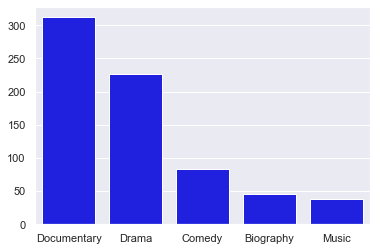

In [50]:
sns.barplot(x=list(top5_g1_genres_dict.keys()), y=list(top5_g1_genres_dict.values()), color='blue')

sum:705
[0.443 0.321 0.118 0.065 0.054]


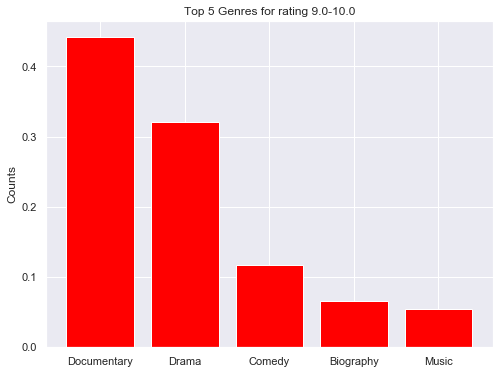

In [57]:
top_5_bar_chart(top5_g1_genres_dict, 'red', 10.0, 9.0)

In [52]:
q2_gA_directors_dict = cal_director_rate(q2_sortedROI_g1_genres_df, 'genres', q2_sortedROI_g1_df_cols, 'A')
q2_gA_directors_dict

13
col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Animation', 'Comedy', 'Music', 'News', 'Romance', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'Game-Show', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']
genre Animation not weighted in group A !
genre Music not weighted in group A !
genre News not weighted in group A !
genre Musical not weighted in group A !
genre Horror not weighted in group A !
genre War not weighted in group A !
genre Family not weighted in group A !
genre Crime not weighted in group A !
genre Fantasy not weighted in group A !
genre Game-Show not weighted in group A !
genre History not weighted in group A !
genre Sci-Fi not weighted in group A !
genre Action not weighted in group A !
genre Mystery not weighted in group A !
genre Wester

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Jonathon Link': 20,
 'Taylor Morden': 16,
 'Linda Palmer': 16,
 'J.J. Harting': 16,
 'Tim Hahne': 14,
 'Joey Daoud': 12,
 'Luke Coffee': 12,
 'Gregg R. Simpson': 12,
 'Richard Krevolin': 12,
 'Horne Brothers': 11}

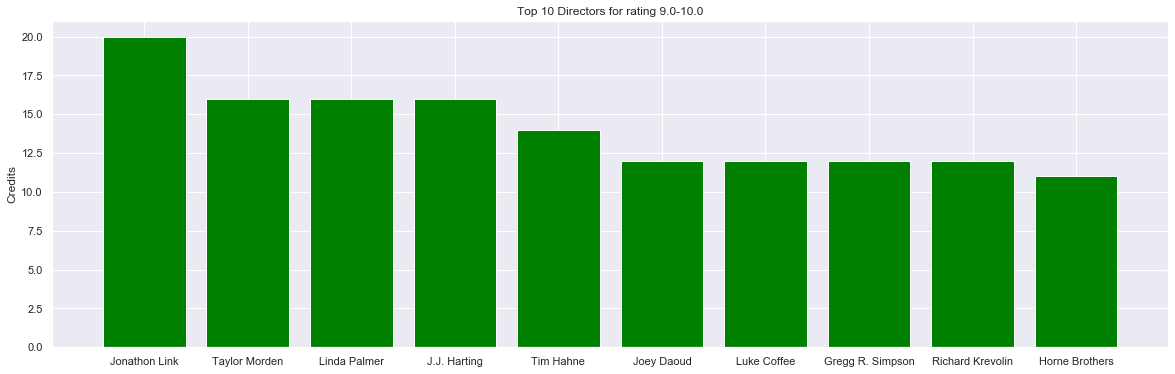

In [60]:
top_10_bar_chart(q2_gA_directors_dict, 'green', 10.0, 9.0)

### Group 2: rating range from 8.0 to 9.0

In [61]:
q2_sortedROI_g2_genres_df = gen_genre_cols(q2_sortedROI_g2_df, 'genres')
print(q2_sortedROI_g2_genres_df.shape)
q2_sortedROI_g2_genres_df.head()

(4065, 37)


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Maceo Frost,nm8121095,"director,assistant_director,editor","tt5691876,tt6628588,tt7269234",tt7269234,5,director,Too Beautiful: Our Right to Fight,Too Beautiful: Our Right to Fight,2018,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jared Scheib,nm3508702,"sound_department,director,cinematographer","tt1481538,tt1744662,tt1370870,tt1647988",tt1744662,5,director,The Mayor,The Mayor,2011,"[Comedy, Documentary, Drama]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Federico Peretti,nm1493893,"editor,director,writer","tt0826217,tt2204355,tt0431964,tt2806728",tt2806728,5,director,Esos colores que llevás,Esos colores que llevás,2013,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mark Moormann,nm0602128,"cinematographer,camera_department,director","tt2063643,tt1539288,tt0343107,tt2814502",tt2814502,5,director,The Record Man,The Record Man,2015,"[Biography, Documentary, History]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Elizabeth Blake-Thomas,nm6230910,"producer,director,writer","tt6170432,tt7294234,tt6226212,tt5951832",tt6226212,5,director,Sand Angels,Sand Angels,2018,[Family],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
q2_sortedROI_g2_genres_df = fill_genre_type(q2_sortedROI_g2_genres_df, 'genres')
print(q2_sortedROI_g2_genres_df.shape)
q2_sortedROI_g2_genres_df.head()

(4065, 37)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Maceo Frost,nm8121095,"director,assistant_director,editor","tt5691876,tt6628588,tt7269234",tt7269234,5,director,Too Beautiful: Our Right to Fight,Too Beautiful: Our Right to Fight,2018,[Documentary],...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jared Scheib,nm3508702,"sound_department,director,cinematographer","tt1481538,tt1744662,tt1370870,tt1647988",tt1744662,5,director,The Mayor,The Mayor,2011,"[Comedy, Documentary, Drama]",...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Federico Peretti,nm1493893,"editor,director,writer","tt0826217,tt2204355,tt0431964,tt2806728",tt2806728,5,director,Esos colores que llevás,Esos colores que llevás,2013,[Documentary],...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mark Moormann,nm0602128,"cinematographer,camera_department,director","tt2063643,tt1539288,tt0343107,tt2814502",tt2814502,5,director,The Record Man,The Record Man,2015,"[Biography, Documentary, History]",...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Elizabeth Blake-Thomas,nm6230910,"producer,director,writer","tt6170432,tt7294234,tt6226212,tt5951832",tt6226212,5,director,Sand Angels,Sand Angels,2018,[Family],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
q2_sortedROI_g2_genres_df.drop('genres', axis=1, inplace=True)

In [64]:
q2_g2_genres_dict = cal_genre_type(q2_sortedROI_g2_genres_df, 'genres', q2_sortedROI_g2_df_cols)
q2_g2_genres_dict

col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'Romance', 'News', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Short', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']


{'Reality-TV': 1,
 'Animation': 60,
 'Comedy': 835,
 'Music': 266,
 'Romance': 289,
 'News': 42,
 'Musical': 87,
 'Horror': 89,
 'War': 55,
 'Family': 219,
 'Crime': 285,
 'Fantasy': 86,
 'History': 247,
 'Short': 1,
 'Sci-Fi': 56,
 'Documentary': 1375,
 'Thriller': 349,
 'Action': 327,
 'Biography': 360,
 'Mystery': 160,
 'Drama': 2023,
 'Western': 17,
 'Sport': 110,
 'Adventure': 186}

#### Top 5 genres of movies in rating range 8.0 - 9.0

In [65]:
top5_g2_genres = sorted(q2_g2_genres_dict, key=q2_g2_genres_dict.get, reverse=True)[:5]
top5_g2_genres

['Drama', 'Documentary', 'Comedy', 'Biography', 'Thriller']

In [66]:
top5_g2_genres_dict = {k:v for k,v in sorted(q2_g2_genres_dict.items(), key=lambda x:x[1], reverse=True)[:5]}
top5_g2_genres_dict

{'Drama': 2023,
 'Documentary': 1375,
 'Comedy': 835,
 'Biography': 360,
 'Thriller': 349}

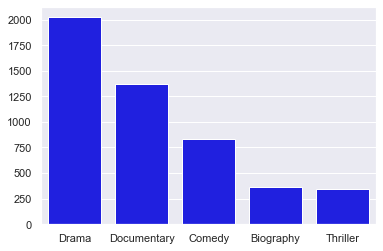

In [67]:
sns.barplot(x=list(top5_g2_genres_dict.keys()), y=list(top5_g2_genres_dict.values()), color='blue')

sum:4942
[0.409 0.278 0.169 0.073 0.071]


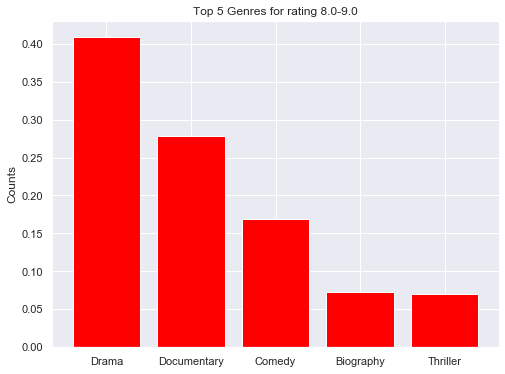

In [68]:
top_5_bar_chart(top5_g2_genres_dict, 'red', 9.0, 8.0)

In [69]:
q2_gB_directors_dict = cal_director_rate(q2_sortedROI_g2_genres_df, 'genres', q2_sortedROI_g2_df_cols, 'B')
q2_gB_directors_dict

13
col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'Romance', 'News', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Short', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']
genre Reality-TV not weighted in group B !
genre Animation not weighted in group B !
genre Music not weighted in group B !
genre News not weighted in group B !
genre Musical not weighted in group B !
genre Horror not weighted in group B !
genre War not weighted in group B !
genre Family not weighted in group B !
genre Crime not weighted in group B !
genre Fantasy not weighted in group B !
genre History not weighted in group B !
genre Short not weighted in group B !
genre Sci-Fi not weighted in group B !
genre Action not weighted in group B !
gen

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Larry Rosen': 128,
 'Robin Lough': 54,
 'Martin Scorsese': 45,
 'Tim Van Someren': 44,
 'Mattias Löw': 36,
 'Barry Avrich': 36,
 'Anurag Kashyap': 36,
 'Sonia Anderson': 35,
 'Dan Steadman': 33,
 'Nick Wickham': 30}

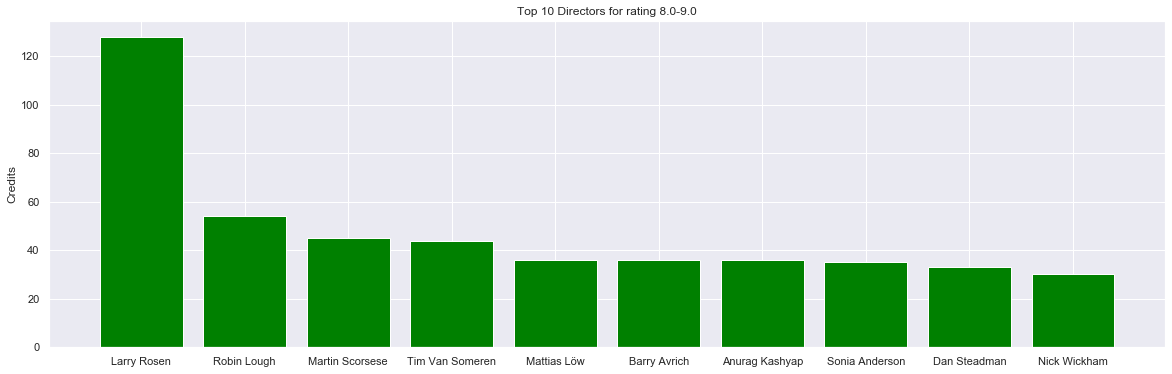

In [70]:
top_10_bar_chart(q2_gB_directors_dict, 'green', 9.0, 8.0)

### Group 3: rating range from 7.0 to 8.0

In [71]:
q2_sortedROI_g3_genres_df = gen_genre_cols(q2_sortedROI_g3_df, 'genres')
print(q2_sortedROI_g3_genres_df.shape)
q2_sortedROI_g3_genres_df.head()

(10323, 36)


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Scott Haze,nm2020278,"actor,writer,producer","tt1270797,tt2649554,tt1951095,tt2776878",tt3379352,5,director,Mully,Mully,2015,"[Adventure, Biography, Documentary]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kyle Hunt,nm7305785,"director,writer,editor",tt4661358,tt4661358,5,director,Hellstorm,Hellstorm,2015,"[Documentary, History, War]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Benjamin May,nm6887132,"director,producer",tt4169682,tt4169682,5,director,The Legend of Swee' Pea,The Legend of Swee' Pea,2015,"[Animation, Biography, Documentary]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Özkan Çelik,nm6422466,"miscellaneous,director,assistant_director","tt3662730,tt3662764,tt8289986,tt2650286",tt8289986,5,director,My Father's Bones,Babamin Kemikleri,2018,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Elkhan Jafarov,nm0246094,"actor,director","tt3961690,tt2235962,tt6157292,tt2129877",tt3961690,5,director,Dolu,Dolu,2012,[War],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
q2_sortedROI_g3_genres_df = fill_genre_type(q2_sortedROI_g3_genres_df, 'genres')
print(q2_sortedROI_g3_genres_df.shape)
q2_sortedROI_g3_genres_df.head()

(10323, 36)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Scott Haze,nm2020278,"actor,writer,producer","tt1270797,tt2649554,tt1951095,tt2776878",tt3379352,5,director,Mully,Mully,2015,"[Adventure, Biography, Documentary]",...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Kyle Hunt,nm7305785,"director,writer,editor",tt4661358,tt4661358,5,director,Hellstorm,Hellstorm,2015,"[Documentary, History, War]",...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Benjamin May,nm6887132,"director,producer",tt4169682,tt4169682,5,director,The Legend of Swee' Pea,The Legend of Swee' Pea,2015,"[Animation, Biography, Documentary]",...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Özkan Çelik,nm6422466,"miscellaneous,director,assistant_director","tt3662730,tt3662764,tt8289986,tt2650286",tt8289986,5,director,My Father's Bones,Babamin Kemikleri,2018,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Elkhan Jafarov,nm0246094,"actor,director","tt3961690,tt2235962,tt6157292,tt2129877",tt3961690,5,director,Dolu,Dolu,2012,[War],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
q2_sortedROI_g3_genres_df.drop('genres', axis=1, inplace=True)

In [74]:
q2_g3_genres_dict = cal_genre_type(q2_sortedROI_g3_genres_df, 'genres', q2_sortedROI_g3_df_cols)
q2_g3_genres_dict

col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'News', 'Romance', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']


{'Reality-TV': 1,
 'Animation': 284,
 'Comedy': 2577,
 'Music': 491,
 'News': 86,
 'Romance': 1369,
 'Musical': 176,
 'Horror': 511,
 'War': 191,
 'Family': 594,
 'Crime': 928,
 'Fantasy': 341,
 'History': 702,
 'Sci-Fi': 290,
 'Documentary': 2535,
 'Thriller': 1168,
 'Action': 1145,
 'Biography': 1010,
 'Mystery': 485,
 'Drama': 5939,
 'Western': 38,
 'Sport': 288,
 'Adventure': 642}

#### Top 5 genres of movies in rating range 7.0 - 8.0

In [75]:
top5_g3_genres = sorted(q2_g3_genres_dict, key=q2_g3_genres_dict.get, reverse=True)[:5]
top5_g3_genres

['Drama', 'Comedy', 'Documentary', 'Romance', 'Thriller']

In [76]:
top5_g3_genres_dict = {k:v for k,v in sorted(q2_g3_genres_dict.items(), key=lambda x:x[1], reverse=True)[:5]}
top5_g3_genres_dict

{'Drama': 5939,
 'Comedy': 2577,
 'Documentary': 2535,
 'Romance': 1369,
 'Thriller': 1168}

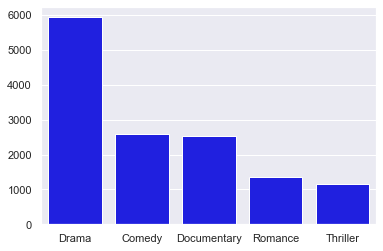

In [77]:
sns.barplot(x=list(top5_g3_genres_dict.keys()), y=list(top5_g3_genres_dict.values()), color='blue')

sum:13588
[0.437 0.19  0.187 0.101 0.086]


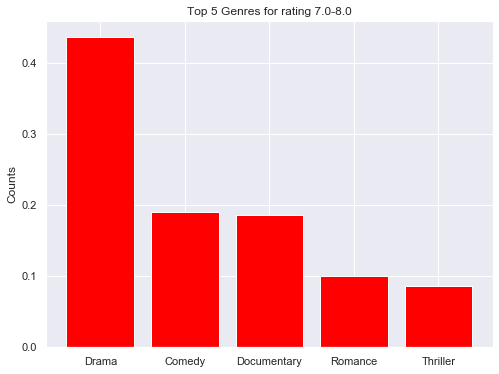

In [78]:
top_5_bar_chart(top5_g3_genres_dict, 'red', 8.0, 7.0)

In [79]:
q2_gC_directors_dict = cal_director_rate(q2_sortedROI_g3_genres_df, 'genres', q2_sortedROI_g3_df_cols, 'C')
q2_gC_directors_dict

13
col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'News', 'Romance', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']
genre Reality-TV not weighted in group C !
genre Animation not weighted in group C !
genre Music not weighted in group C !
genre News not weighted in group C !
genre Musical not weighted in group C !
genre Horror not weighted in group C !
genre War not weighted in group C !
genre Family not weighted in group C !
genre Crime not weighted in group C !
genre Fantasy not weighted in group C !
genre History not weighted in group C !
genre Sci-Fi not weighted in group C !
genre Action not weighted in group C !
genre Mystery not weighted in group C !
genre West

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Barry Avrich': 120,
 'Michael Fredianelli': 96,
 'Takahiro Miki': 96,
 'Srijit Mukherji': 90,
 'Yoshihiro Nakamura': 90,
 'Angga Dwimas Sasongko': 84,
 'Lav Diaz': 80,
 'Jason Paul Laxamana': 78,
 'Steven Spielberg': 78,
 'Dan Villegas': 77}

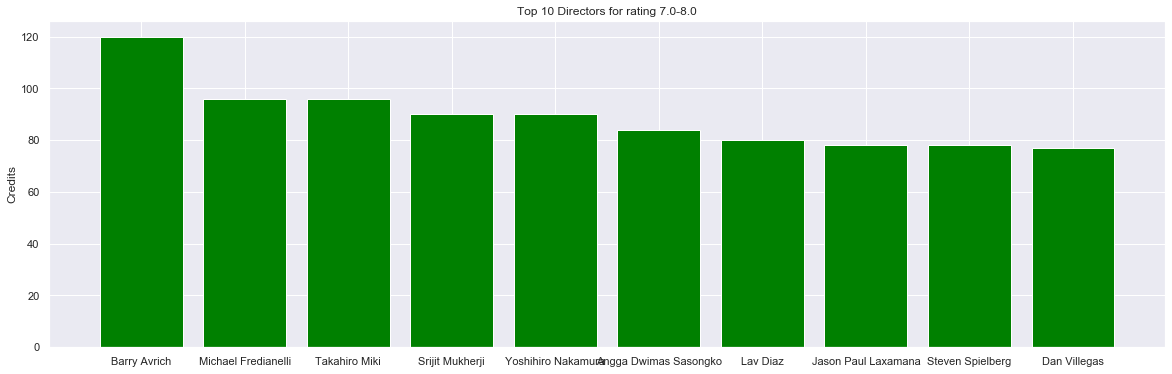

In [80]:
top_10_bar_chart(q2_gC_directors_dict, 'green', 8.0, 7.0)

### Group 4: rating range from 6.0 to 7.0

In [81]:
q2_sortedROI_g4_genres_df = gen_genre_cols(q2_sortedROI_g4_df, 'genres')
print(q2_sortedROI_g4_genres_df.shape)
q2_sortedROI_g4_genres_df.head()

(14719, 36)


C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Sandy Chronopoulos,nm5441361,"producer,director,writer","tt5321568,tt2558544",tt5321568,5,director,House of Z,House of Z,2017,[Documentary],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ehsan Biglari,nm8553324,"writer,director,assistant_director","tt6209534,tt0845439,tt6208104,tt6215590",tt6208104,5,director,My Brother Khosrow,Baradaram Khosro,2016,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Serif Gören,nm0351410,"director,writer,editor","tt0492381,tt0071466,tt0353347,tt0084934",tt6847792,5,director,Yol: The Full Version,Yol: The Full Version,2017,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Toshiaki Toyoda,nm0870313,"director,writer,cinematographer","tt7268368,tt0370244,tt0460845,tt0309291",tt7268368,5,director,The Miracle of Crybaby Shottan,Nakimushi Shottan no Kiseki,2018,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quentin Dupieux,nm1189197,"director,writer,cinematographer","tt2392672,tt7156222,tt1612774,tt1901040",tt2392672,5,director,Reality,Réalité,2014,[Comedy],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
q2_sortedROI_g4_genres_df = fill_genre_type(q2_sortedROI_g4_genres_df, 'genres')
print(q2_sortedROI_g4_genres_df.shape)
q2_sortedROI_g4_genres_df.head()

(14719, 36)


,nconst,primary_profession,known_for_titles,tconst,ordering,category,primary_title,original_title,start_year,genres,...,Sci-Fi,Documentary,Thriller,Action,Biography,Mystery,Drama,Western,Sport,Adventure
primary_name,,,,,,,,,,,,,,,,,,,,,
Sandy Chronopoulos,nm5441361,"producer,director,writer","tt5321568,tt2558544",tt5321568,5,director,House of Z,House of Z,2017,[Documentary],...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ehsan Biglari,nm8553324,"writer,director,assistant_director","tt6209534,tt0845439,tt6208104,tt6215590",tt6208104,5,director,My Brother Khosrow,Baradaram Khosro,2016,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Serif Gören,nm0351410,"director,writer,editor","tt0492381,tt0071466,tt0353347,tt0084934",tt6847792,5,director,Yol: The Full Version,Yol: The Full Version,2017,[Drama],...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Toshiaki Toyoda,nm0870313,"director,writer,cinematographer","tt7268368,tt0370244,tt0460845,tt0309291",tt7268368,5,director,The Miracle of Crybaby Shottan,Nakimushi Shottan no Kiseki,2018,[Drama],...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Quentin Dupieux,nm1189197,"director,writer,cinematographer","tt2392672,tt7156222,tt1612774,tt1901040",tt2392672,5,director,Reality,Réalité,2014,[Comedy],...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [83]:
q2_sortedROI_g4_genres_df.drop('genres', axis=1, inplace=True)

In [84]:
q2_g4_genres_dict = cal_genre_type(q2_sortedROI_g4_genres_df, 'genres', q2_sortedROI_g4_df_cols)
q2_g4_genres_dict

col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'Romance', 'News', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']


{'Reality-TV': 1,
 'Animation': 296,
 'Comedy': 4807,
 'Music': 424,
 'Romance': 2554,
 'News': 45,
 'Musical': 222,
 'Horror': 1291,
 'War': 272,
 'Family': 990,
 'Crime': 1612,
 'Fantasy': 718,
 'History': 721,
 'Sci-Fi': 564,
 'Documentary': 1524,
 'Thriller': 2267,
 'Action': 1921,
 'Biography': 960,
 'Mystery': 998,
 'Drama': 9506,
 'Western': 78,
 'Sport': 304,
 'Adventure': 1010}

#### Top 5 genres of movies in rating range 6.0 - 7.0

In [85]:
top5_g4_genres = sorted(q2_g4_genres_dict, key=q2_g4_genres_dict.get, reverse=True)[:5]
top5_g4_genres

['Drama', 'Comedy', 'Romance', 'Thriller', 'Action']

In [86]:
top5_g4_genres_dict = {k:v for k,v in sorted(q2_g4_genres_dict.items(), key=lambda x:x[1], reverse=True)[:5]}
top5_g4_genres_dict

{'Drama': 9506,
 'Comedy': 4807,
 'Romance': 2554,
 'Thriller': 2267,
 'Action': 1921}

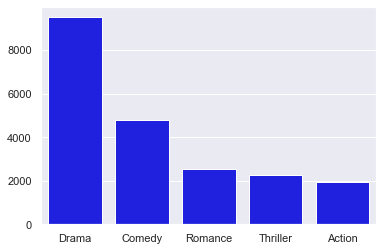

In [87]:
sns.barplot(x=list(top5_g4_genres_dict.keys()), y=list(top5_g4_genres_dict.values()), color='blue')

sum:21055
[0.451 0.228 0.121 0.108 0.091]


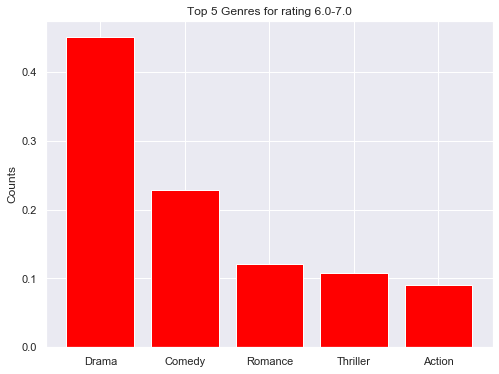

In [88]:
top_5_bar_chart(top5_g4_genres_dict, 'red', 7.0, 6.0)

In [89]:
q2_gD_directors_dict = cal_director_rate(q2_sortedROI_g4_genres_df, 'genres', q2_sortedROI_g4_df_cols, 'D')
q2_gD_directors_dict

13
col list is ['nconst', 'primary_profession', 'known_for_titles', 'tconst', 'ordering', 'category', 'primary_title', 'original_title', 'start_year', 'directors', 'averagerating', 'numvotes', 'Reality-TV', 'Animation', 'Comedy', 'Music', 'Romance', 'News', 'Musical', 'Horror', 'War', 'Family', 'Crime', 'Fantasy', 'History', 'Sci-Fi', 'Documentary', 'Thriller', 'Action', 'Biography', 'Mystery', 'Drama', 'Western', 'Sport', 'Adventure']
genre Reality-TV not weighted in group D !
genre Animation not weighted in group D !
genre Music not weighted in group D !
genre News not weighted in group D !
genre Musical not weighted in group D !
genre Horror not weighted in group D !
genre War not weighted in group D !
genre Family not weighted in group D !
genre Crime not weighted in group D !
genre Fantasy not weighted in group D !
genre History not weighted in group D !
genre Sci-Fi not weighted in group D !
genre Action not weighted in group D !
genre Mystery not weighted in group D !
genre West

C:\Users\renjm\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Takashi Miike': 240,
 'Yukihiko Tsutsumi': 153,
 'Herman Yau': 136,
 'Sang-soo Hong': 132,
 'Ryuichi Hiroki': 132,
 'Yoshihiro Fukagawa': 121,
 'Sion Sono': 119,
 'Sandip Ray': 98,
 'Jun Lana': 90,
 'Keisuke Yoshida': 90}

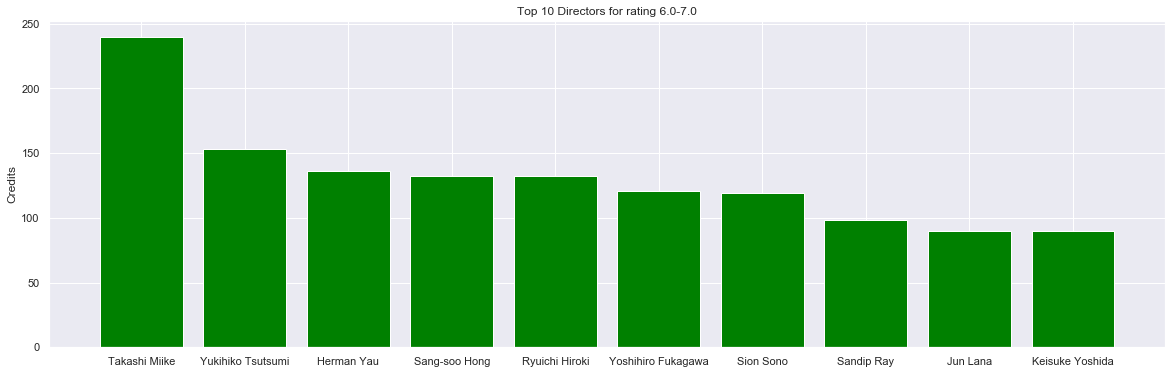

In [90]:
top_10_bar_chart(q2_gD_directors_dict, 'green', 7.0, 6.0)

## Money plot 

In [ ]:
data1 = [{'Genre': 'Documentary', 'Rate': 'A (9-10)', 'Ratio': 0.443},
         {'Genre': 'Documentary', 'Rate': 'B (8-9)', 'Ratio': 0.278},
         {'Genre': 'Documentary', 'Rate': 'C (7-8)', 'Ratio': 0.187},
         {'Genre': 'Documentary', 'Rate': 'D (6-7)', 'Ratio': 0.000},
         {'Genre': 'Drama', 'Rate': 'A (9-10)', 'Ratio': 0.321},
         {'Genre': 'Drama', 'Rate': 'B (8-9)', 'Ratio': 0.409},
         {'Genre': 'Drama', 'Rate': 'C (7-8)', 'Ratio': 0.437},
         {'Genre': 'Drama', 'Rate': 'D (6-7)', 'Ratio': 0.451},
         {'Genre': 'Comedy', 'Rate': 'A (9-10)', 'Ratio': 0.118},
         {'Genre': 'Comedy', 'Rate': 'B (8-9)', 'Ratio': 0.169},
         {'Genre': 'Comedy', 'Rate': 'C (7-8)', 'Ratio': 0.190},
         {'Genre': 'Comedy', 'Rate': 'D (6-7)', 'Ratio': 0.228},
         {'Genre': 'Biography', 'Rate': 'A (9-10)', 'Ratio': 0.065},
         {'Genre': 'Biography', 'Rate': 'B (8-9)', 'Ratio': 0.073},
         {'Genre': 'Biography', 'Rate': 'C (7-8)', 'Ratio': 0.000},
         {'Genre': 'Biography', 'Rate': 'D (6-7)', 'Ratio': 0.000},
         {'Genre': 'Romance', 'Rate': 'A (9-10)', 'Ratio': 0.000},
         {'Genre': 'Romance', 'Rate': 'B (8-9)', 'Ratio': 0.000},
         {'Genre': 'Romance', 'Rate': 'C (7-8)', 'Ratio': 0.101},
         {'Genre': 'Romance', 'Rate': 'D (6-7)', 'Ratio': 0.121},
         {'Genre': 'Thriller', 'Rate': 'A (9-10)', 'Ratio': 0.000},
         {'Genre': 'Thriller', 'Rate': 'B (8-9)', 'Ratio': 0.071},
         {'Genre': 'Thriller', 'Rate': 'C (7-8)', 'Ratio': 0.086},
         {'Genre': 'Thriller', 'Rate': 'D (6-7)', 'Ratio': 0.108}]

data1_df = pd.DataFrame(data1)
data1_df

In [ ]:
pivot = data1_df.pivot(index='Genre', columns='Rate', values='Ratio')
pivot

In [ ]:
pivot.plot(kind='barh', figsize=(15,8), stacked=True)
plt.xlabel('Ratio/Rate')
plt.title('Top 5 Generes in Various Rating Ranges Hired Directors Best Known for')

### Question 2.1: What are Top 5 genres in different rating ranges after 2010?

### Question 2.2: Who are directors making most highest rated movies after 2010?

# 3
## Question 3:  Is most popular genre correlated with director's profession?